In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="Banana2.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
#Get the Default Brain
brain_name = env.brain_names[0]
print(brain_name)

BananaBrain


In [4]:
brain = env.brains[brain_name]
print(brain)

Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info = env.reset(train_mode=True)[brain_name]
print(env_info)

In [6]:
import pprint as pp


In [7]:
# Fetching the number of states and actions
number_of_states = brain.vector_observation_space_size
number_of_actions = brain.vector_action_space_size
number_of_agents = len(env_info.agents)
# checking the total number of states and action
print('Total number of States : {}'.format(number_of_states)) 
print('Total number of Actions : {}'.format(number_of_actions))
print('Total number of Agents : {}'.format(number_of_agents))

#Examine the State Space
state = env_info.vector_observations[0]
print("State Looks Like: ")
pp.pprint(state)

Total number of States : 37
Total number of Actions : 4
Total number of Agents : 1
State Looks Like: 
array([1.        , 0.        , 0.        , 0.        , 0.84408134,
       0.        , 0.        , 1.        , 0.        , 0.0748472 ,
       0.        , 1.        , 0.        , 0.        , 0.25755   ,
       1.        , 0.        , 0.        , 0.        , 0.74177343,
       0.        , 1.        , 0.        , 0.        , 0.25854847,
       0.        , 0.        , 1.        , 0.        , 0.09355672,
       0.        , 1.        , 0.        , 0.        , 0.31969345,
       0.        , 0.        ])


In [8]:
#importing the required Library
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import random 


import math

In [9]:
#Selecting the available device (cpu/gpu)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [10]:
NUMBER_OF_EPISODES = 500 #700
MAX_STEPS = 1000 #1000
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
HIDDEN_LAYER_SIZE = 64

EGREEDY = 0.9
EGREEDY_FINAL = 0.02
EGREEDY_DECAY = 500

REPLAY_BUFFER_SIZE = 6000
BATCH_SIZE = 32

UPDATE_TARGET_FREQUENCY = 4

In [11]:
def calculate_epsilon(steps_done):
    """
    Decays eplison with increasing steps
    Parameter:
    steps_done (int) : number of steps completed
    Returns:
    int - decayed epsilon
    """
    epsilon = EGREEDY_FINAL + (EGREEDY - EGREEDY_FINAL) * \
              math.exp(-1. * steps_done / EGREEDY_DECAY )
    return epsilon

In [12]:
# Deep Q Network Model Archietecture

class DQN(nn.Module):
    def __init__(self , hidden_layer_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.fc1 = nn.Linear(number_of_states,self.hidden_layer_size)
        self.fc2 = nn.Linear(self.hidden_layer_size,number_of_actions)

    def forward(self, x):
        output = torch.tanh(self.fc1(x))
        output = self.fc2(output)
        return output

In [13]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.buffer = []
        self.pointer = 0
        
    def push(self, state, action, new_state, reward, done):
        experience = (state, action, new_state, reward, done)
        if self.pointer >= len(self.buffer):
            self.buffer.append(experience)
        else:
            self.buffer[self.pointer] = experience
            
        self.pointer = (self.pointer + 1) % self.capacity
        
    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))
    
    def __len__(self):
        return len(self.buffer)

In [14]:
memory = ExperienceReplay(REPLAY_BUFFER_SIZE)

In [15]:
class DQN_Agent(object):
    def __init__(self):
        
        self.dqn = DQN(HIDDEN_LAYER_SIZE).to(device)
        self.target_dqn = DQN(HIDDEN_LAYER_SIZE).to(device)
        
        self.criterion = torch.nn.MSELoss()
        
        self.optimizer = optim.Adam(params=self.dqn.parameters() , lr=LEARNING_RATE)
        
        self.target_dqn_update_counter = 0
    
    def select_action(self,state,EGREEDY):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > EGREEDY:      
            
            with torch.no_grad():
                
                state = torch.Tensor(state).to(device)
                q_values = self.dqn(state)
                action = torch.max(q_values,0)[1]
                action = action.item()        
        else:
            action = np.random.randint(4) 
        
        return action
    
    def optimize(self):
        
        if (BATCH_SIZE > len(memory)):
            return
        
        state, action, new_state, reward, done = memory.sample(BATCH_SIZE)
        
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)
        
        # select action : get the index associated with max q value from prediction network
        new_state_indxs = self.dqn(new_state).detach() 
        max_new_state_indxs = torch.max(new_state_indxs, 1)[1] # to get the max new state indexes
        
        
        # Using the best action from the prediction nn get the max new state value in target dqn
        new_state_values = self.target_dqn(new_state).detach()
        max_new_state_values = new_state_values.gather(1, max_new_state_indxs.unsqueeze(1)).squeeze(1)
        
        
        target_value = reward + (1 - done) * DISCOUNT_FACTOR * max_new_state_values #when done = 1 then target = reward
        
        predicted_value = self.dqn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        
        loss = self.criterion(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.target_dqn_update_counter % UPDATE_TARGET_FREQUENCY == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())
        
        self.target_dqn_update_counter += 1

In [16]:
# Instantiating the DQN Agent
dqn_agent = DQN_Agent()

In [17]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
#state = env_info.vector_observations[0] 
steps_total = []
steps_counter = 0
for episode in range(NUMBER_OF_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    done = False
    step = 0
    score = 0
    for i in range(MAX_STEPS):
        step += 1
        steps_counter += 1
        #print(steps_total)
        #print(step)
      
        EGREEDY = calculate_epsilon(steps_counter)

        action = dqn_agent.select_action(state, EGREEDY)
          
        env_info = env.step(action)[brain_name]
        
        new_state = env_info.vector_observations[0]
        #print(new_state) # get the next state
        reward = env_info.rewards[0]
        #print(reward)
        # get the reward
        done = env_info.local_done[0]
        #print(done)
        # see if episode has finished
                       # update the score
        score += reward 
        #print(score)
        
        memory.push(state, action, new_state, reward, done)
        dqn_agent.optimize()
      
        state = new_state
        #print(state)

        if done:
            #print(done)
            steps_total.append(score)
            break
    

In [18]:
print("Average reward: %.2f" % (sum(steps_total)/NUMBER_OF_EPISODES))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

Average reward: 8.92
Average reward (last 100 episodes): 11.68


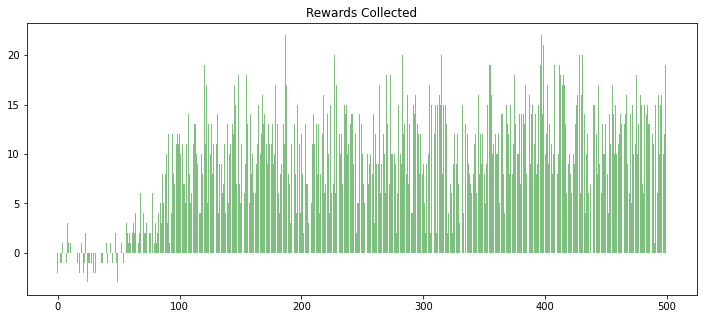

In [19]:
plt.figure(figsize=(12,5))
plt.title("Rewards Collected")
plt.bar(np.arange(len(steps_total)), steps_total, alpha=0.5, color='green')
plt.show()

Text(0, 0.5, 'Episode Reward')

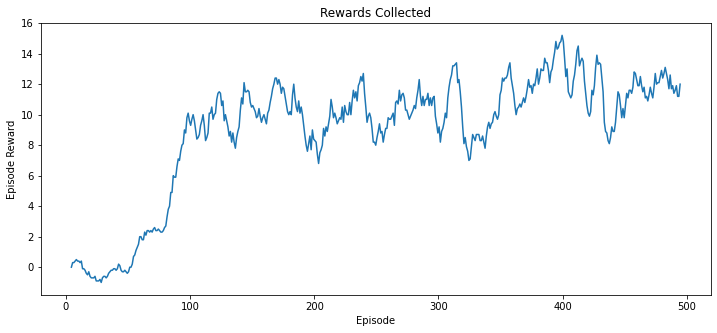

In [20]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

#episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(steps_total, 10)
cum_l = get_running_stat(np.arange(len(steps_total)), 10)

plt.figure(figsize=(12,5))
plt.title("Rewards Collected")
# plot rewards
plt.plot(cum_l, cum_r)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

In [21]:
env.close()